In [1]:
import numpy as np
import pandas as pd
import json
import math
import calendar

# Feature Selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# tqdm package to show progress in loops
from tqdm import tqdm

from pprint import pprint

import os

## Part 1

### Logins File

In [3]:
# read 'ultimate data challenge' file
with open('logins.json', 'r') as myfile:
    data=myfile.read()
    
logins = json.loads(data)

In [4]:
logins_df = pd.DataFrame(logins)

In [5]:
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [6]:
logins_df.dtypes

login_time    object
dtype: object

In [7]:
logins_df['login_time'] = pd.to_datetime(logins_df['login_time'])

In [8]:
logins_df.describe(datetime_is_numeric=True)

,login_time
count,93142
mean,1970-02-26 19:09:39.779648278
min,1970-01-01 20:12:16
25%,1970-02-04 10:37:19.750000
50%,1970-03-01 06:33:05.500000
75%,1970-03-22 04:01:10.750000
max,1970-04-13 18:57:38


<AxesSubplot:title={'center':'Longterm trend of frequency of logins'}>

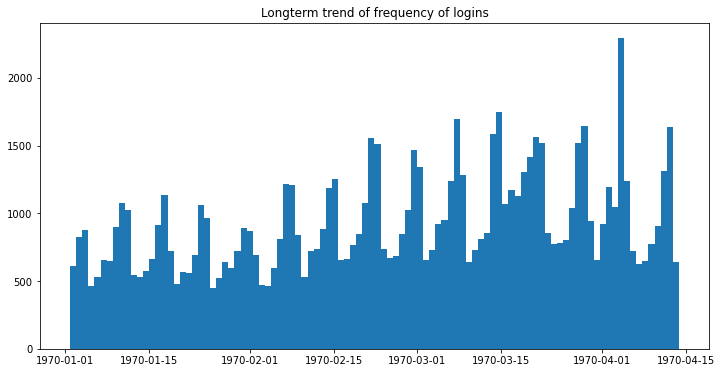

In [9]:
plt.figure(figsize=(12,6))
plt.title('Longterm trend of frequency of logins')
logins_df['login_time'].hist(bins=100, grid=False)

What is the distribution of logins during each month, day of week, and hour of day?

In [10]:
# set datetime to index for resample function and start "counts" column
counts = logins_df.set_index('login_time')

counts['count'] = 1
counts.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [11]:
counts15m = counts.resample('15T').count()
counts15m.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


### Monthly Profiles

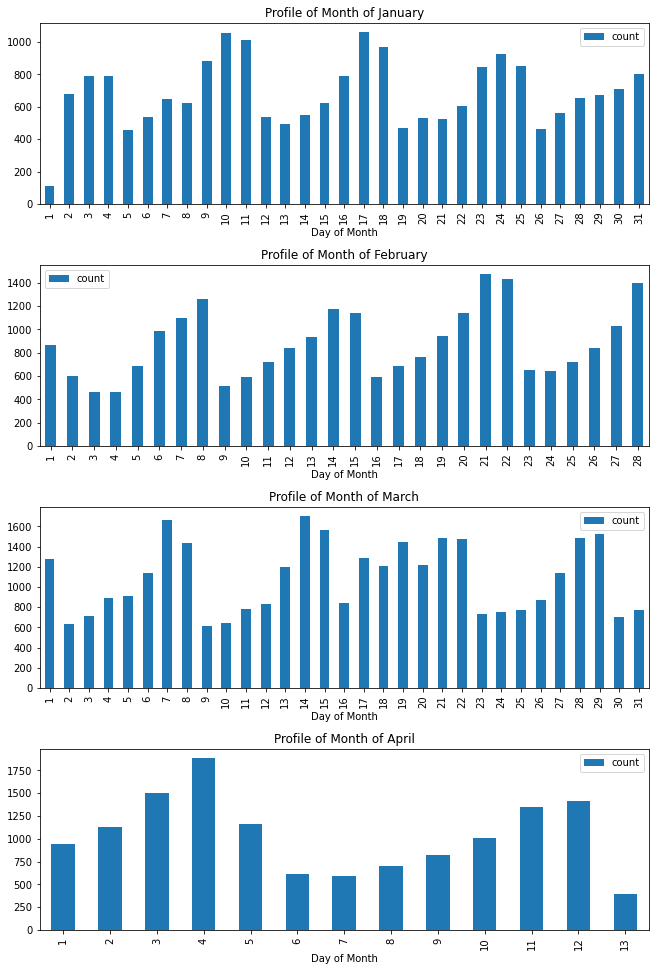

In [12]:
nrows = 4
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,14))
fig.tight_layout(pad=4)

for monthbin, monthdata in counts15m.groupby(counts15m.index.month):
    row = monthbin -1 # subtract 1 because number of 1st month is 1
    monthdata.groupby(monthdata.index.day).sum().plot(ax=ax[row], kind='bar', 
    title='Profile of Month of {}'.format(calendar.month_name[monthbin]), xlabel='Day of Month')

### Daily Profiles

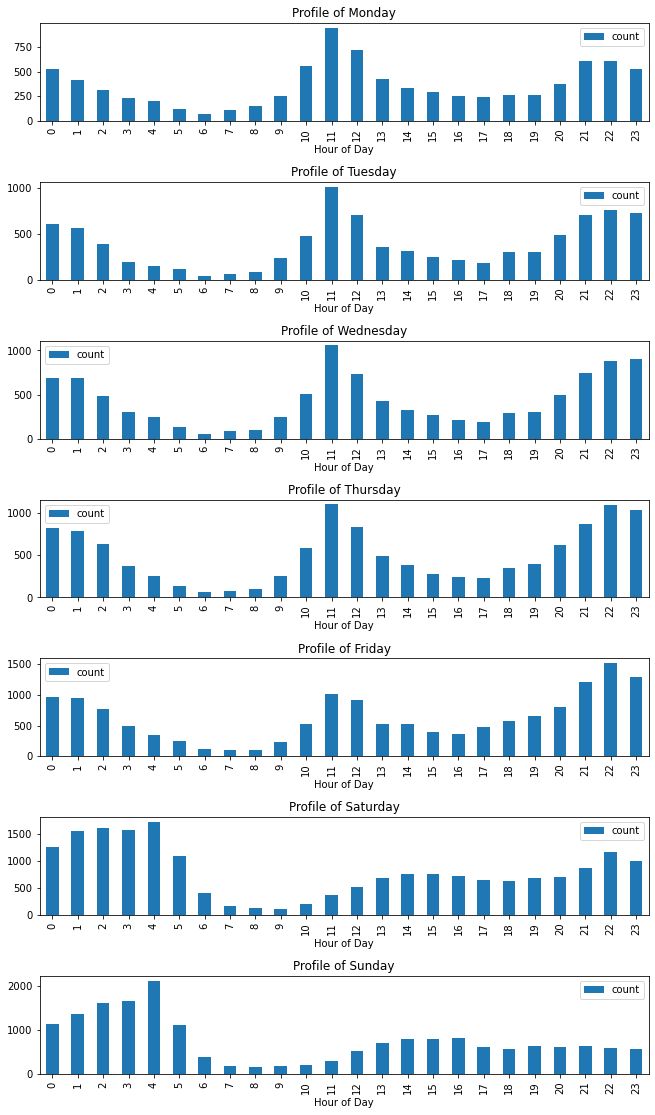

In [13]:
nrows = 7
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,16))
fig.tight_layout(pad=4)

for daybin, daydata in counts15m.groupby(counts15m.index.weekday):
    row = math.floor(daybin/ncols)
    daydata.groupby(daydata.index.hour).sum().plot(ax=ax[row], kind='bar', 
    title='Profile of {}'.format(calendar.day_name[daybin]), xlabel='Hour of Day')

### Hourly Profiles

The hourly login profiles are more uniform. However, certain hours provide more detail about where the change in daily logins changes most rapidly. The daily profiles show that logins tend to drop from hour 4 to hour 5, but where does the change occur exactly? The hourly profile shows that it does not tend to drop until 15 minutes into hour 5.

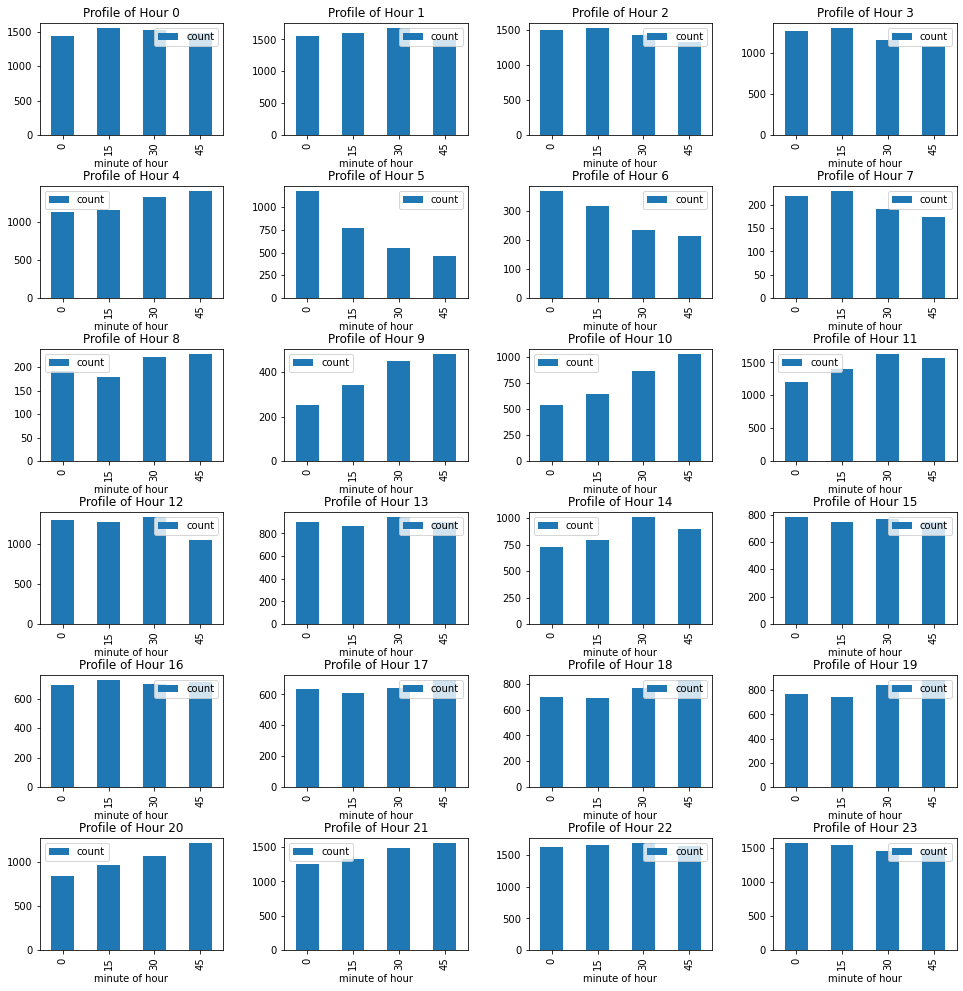

In [14]:
nrows = 6
ncols = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,14))
fig.tight_layout(pad=3)

for hourbin, hourdata in counts15m.groupby(counts15m.index.hour):
    row = math.floor(hourbin/ncols)
    col = hourbin - row*ncols
    hourdata.groupby(hourdata.index.minute).sum().plot(ax=ax[row, col], kind='bar', 
    title='Profile of Hour {}'.format(hourbin), xlabel='minute of hour')

## Part 2

**1)** The toll bridge would hamper activity when there is demand for drivers that would otherwise be available. If there is a shortage of drivers in Metropolis at night, there could potentially be drivers in Gotham who could help meet the demand of riders. The same would be true of demand for Gotham drivers during the day.

The average number of trips during each hour before toll-reimbursement can be compared to the average number of trips in those hours after toll-reimbursement to test for statistically significant change. The ideal result would show a change in activity during nighttime hours in Metropolis but no statistically significant change during daytime hours, since the Gotham drivers would not be providing extra capacity during the day.

What isn't known is how much the demand for drivers outstrips the actual demand from riders during each portion of the day. For example, if the number of trips in Metropolis is low at 11:00 PM on Monday, is this because a limited supply of drivers were at maximum capacity, or were there simply very few requests for drivers at this time, regardless of availability?



**2)** I would perform a t-test to compare the average number of trips per hour pre- and post- toll-reimbursement. I would first remove weekends because there is less difference between the two cities per the question instructions. I would then group each the pre- and post- data sets by hour and run a t-test between groups for each individual hour.

As Ultimate Technologies is likely a growing company with a longterm trend of increasing number of trips per day, I would perform pre-processing to correct for the growth trend that is independent of the toll-reimbursment experiment. I would first divide each data set into a peak-hour subset and off-peak hour subset. Activity from the neighboring city should not affect the supply/demand ratio during peak hours because of opposite circadian rhythms. I would calculate growth in activity during peak hours beteen post- and pre- data sets and then normalize all hours in the post- data set by dividing by the growth factor.

I would then compare each normalized off-peak hour between pre- and post- groups using a t-test and report a 90% confidence interval of the magnitude of percentage increase (or decrease) in activity from toll-reimbursement. A trend in increasing effect as a city moves into off-peak hours would support the hypothesis that complimentary circadian rhythms are benefitting times of shortage in demand.

## Part 3

### EDA and Cleaning

In [15]:
# read 'ultimate data challenge' file
with open('ultimate_data_challenge.json', 'r') as myfile:
    data=myfile.read()
    
data = json.loads(data)

In [16]:
df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [17]:
df.shape

(50000, 12)

In [18]:
df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [19]:
# Convert dates to datetime object
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [20]:
df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [21]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [22]:
df.isna().sum(axis=0)

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

There are some missing variables that need to be removed or filled in; most significantly, average rating of driver. The options are filling it with a typical value to minimize impact, or dropping it completely. Average rating of driver should be important and the ratings are skewed high such that the majority get close to 5 stars. Filling with the mean is not a good option because it has a good chance of attributing a good review to the cases where the driver was perceived poorly and which resulted in customer loss. The values will be dropped.

It's less clear how avg_rating_by_driver would affect customer retention, and there are fewer missing values. There could be "problematic" customers that are difficult to work with. These should be dropped to avoid skewing results.

Type of phone should not be predictive of rider retention, but different phone types may tend to be used by different demographics. These rows will also be dropped instead of using the mode.

In [23]:
df.dropna(inplace=True)

In [24]:
df.isna().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [25]:
df.shape

(41445, 12)

In [26]:
# Create column for verifiable length of retention
df['range_active'] = df['last_trip_date']-df['signup_date']
df['range_active'].dtype

dtype('<m8[ns]')

In [27]:
# Convert TimeDelta object to float64
df['range_active'] = df['range_active'].dt.total_seconds()/(24*60*60)
df['range_active'].dtype

dtype('float64')

View range of how long customers were active.

Text(0.5, 1.0, 'Histogram of Range of Days Active')

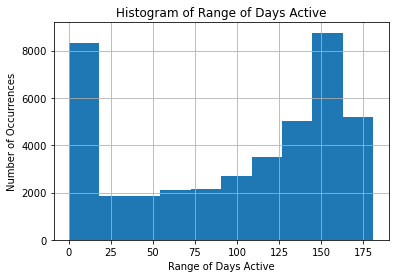

In [28]:
df['range_active'].hist()
plt.xlabel('Range of Days Active')
plt.ylabel('Number of Occurrences')
plt.title('Histogram of Range of Days Active')

Classify customers into active versus inactive. Assume the last trip date in the data is approximately when the data was pulled. This is reasonable because there are 529 trips on that day.

In [29]:
# Add column to indicate number of days since last active
df['last_trip_date'][df['last_trip_date'] == df['last_trip_date'].max()]

17      2014-07-01
87      2014-07-01
96      2014-07-01
147     2014-07-01
297     2014-07-01
           ...    
49515   2014-07-01
49524   2014-07-01
49557   2014-07-01
49976   2014-07-01
49993   2014-07-01
Name: last_trip_date, Length: 529, dtype: datetime64[ns]

In [30]:
# Add column indicating how many days since last trip
df['days_since_last'] = df['last_trip_date'].max() - df['last_trip_date']

# Convert to float64
df['days_since_last'] = df['days_since_last'].dt.total_seconds()/(24*60*60)

In [31]:
df['is_active'] = df['days_since_last'] <= 30
df['is_active'].head()

0     True
1    False
2    False
3     True
4    False
Name: is_active, dtype: bool

In [32]:
# Drop temporary columns used for calculating is_active
df.drop(columns='days_since_last', inplace=True)

Perform one-hot encoding for categorical variables.

In [33]:
df = pd.get_dummies(df)

In [34]:
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,range_active,is_active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,143.0,True,0,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,96.0,False,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,1.0,False,1,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,170.0,True,0,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,47.0,False,0,0,1,1,0


### Modeling

This is a supervised learning classification problem where whether the user is active is the dependent variable. I am using K-Nearest neighbors because it is a classification algorithm and there are relatively few input variables to analyze. It also makes intuitive sense because we are looking for groups of customers that behave similarly. Other models that could be used for classification are support vector machines and random forests.

I am going to drop the feature I created, 'range_active', because shorter ranges of being active could be because the customer already stopped using the service; the dependent variable would be leaking into the independent variables. In the same vein, last_trip_date is just another way of describing the outcome so should not be considered a predictive variable.

In [35]:
# Drop datetime columns -- these are captured in the numerical 'range_active'
df.drop(columns=['signup_date','last_trip_date', 'range_active' ], inplace=True)

In [36]:
# Split Data
X = df.drop('is_active', axis=1)
y = df['is_active']

<AxesSubplot:>

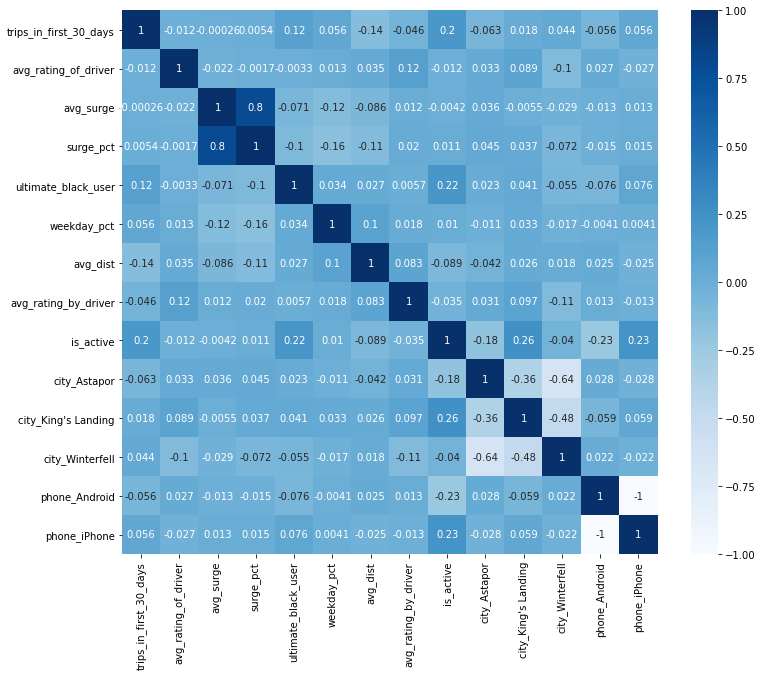

In [37]:
# Look for highly correlated variables
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True,cmap ='Blues')

Most variables are uncorrelated except for surge_pct and avg_surge. These could be combined into a principal component to avoid overweighting the surge metric. However, I will run the model with the individual variables to see if it produces an accurate enough model.

In [38]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [39]:
X_train.dtypes

trips_in_first_30_days      int64
avg_rating_of_driver      float64
avg_surge                 float64
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
city_Astapor                uint8
city_King's Landing         uint8
city_Winterfell             uint8
phone_Android               uint8
phone_iPhone                uint8
dtype: object

In [40]:
# Standardize magnitude of features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


In [41]:
from sklearn.neighbors import KNeighborsClassifier

test_scores = []
train_scores = []

for i in range(1,20):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train_s,y_train)
    
    train_scores.append(knn.score(X_train_s,y_train))
    test_scores.append(knn.score(X_test_s,y_test))

In [42]:
print('train scores: \n', train_scores)
print('test scores: \n', test_scores)

train scores: 
 [0.9978973492813071, 0.8484023301506325, 0.8426458929371617, 0.8152080245424149, 0.8110371927889422, 0.7976974251146117, 0.7956637137637448, 0.789183413188101, 0.7882182620385371, 0.7835993243941953, 0.7825652338768053, 0.7794284926407224, 0.7775326600255076, 0.7768777360311606, 0.7753610699389887, 0.7757747061459447, 0.7734307676398607, 0.7733962979559478, 0.7716038743924718]
test scores: 
 [0.6891587582435258, 0.6970403731703394, 0.7181116294032491, 0.7247868746984076, 0.7302557503619109, 0.7354833520990831, 0.7388611870677175, 0.7423998713205726, 0.7444909120154415, 0.7475470484156346, 0.7491555412578415, 0.7497185137526138, 0.7492359658999518, 0.7497185137526138, 0.7501206369631656, 0.7506031848158276, 0.7510857326684897, 0.751407431236931, 0.7507640341000482]


Plot train and test scores for different numbers of K nearest neighbors.

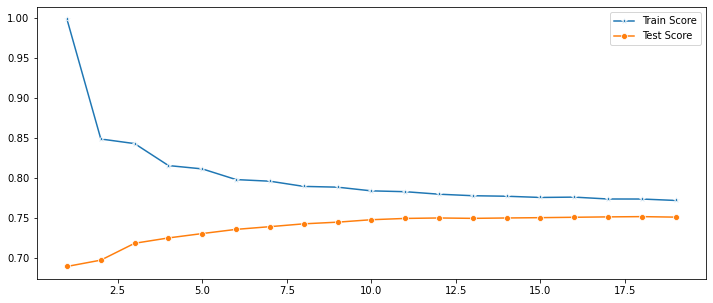

In [43]:
plt.figure(figsize=(12,5))
p = sns.lineplot(x=range(1,20),y=train_scores,marker='*',label='Train Score')
p = sns.lineplot(x=range(1,20),y=test_scores,marker='o',label='Test Score')

The model seems to continually improve as the number of nearest-neighbors increases. The fact that the test score does decrease with a larger K also indicates it is not overfitting. However, the benefit tapers off at around K=10, so I selected this number to go with the simplest model.

In [48]:
    knn = KNeighborsClassifier(10)
    knn.fit(X_train_s, y_train)
    knn.score(X_test_s, y_test)

0.7475470484156346

In [49]:
from sklearn.metrics import confusion_matrix
y_pred = knn.predict(X_test_s)
pl = confusion_matrix(y_test,y_pred)

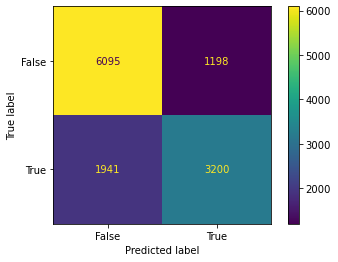

In [50]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(knn, X_test_s, y_test)

In [55]:
# Check accuracy
(3200+6095)/(6095+1198+1941+3200)

0.7475470484156346

In [56]:
# False positives
1198/(1198+3200)

0.2723965438835834

In [57]:
# False negatives
1941/(1941+6095)

0.24153807864609259

In the above confusion matrix, "True" means the customer is active in the past 30 days.

The confusion matrix confirms the accuracy returned by the knn.score function. The false positive and false negative rates are similar. The usefulness depends on how Ultimate Technologies values the the risk of failing to identify individuals that may leave versus the risk of falsely identifying "loyal" customers as potential losses. If the customer-retention measures themselves have a cost, such as offering a free or discounted trip, they may want to use a model that has a higher specificity, even if it is at the cost of accuracy.